# Project 2: Ames Housing Data

**Part 3 Modelling**

**1. Import Libraries**

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics
from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error

%matplotlib inline

In [53]:
# importing engineered Data
df_train = pd.read_csv('D:/GA/DSI3lab/dsi3test/project_2/datasets/train_dummies.csv')

#Set id as index 
df_train.set_index('id', inplace=True)

# Check for nulls
(df_train.isnull().sum())[df_train.isnull().sum() > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [54]:
df_train.shape

(2043, 512)

**2. Features and targeting vector**

In [55]:
features = [col for col in df_train._get_numeric_data().columns if col != 'saleprice']
X = df_train[features]
y = df_train['saleprice']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [57]:
#scaling 
ss =StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

In [58]:
#Instantiate Models
lr = LinearRegression()
lasso = LassoCV(n_alphas = 200)
ridge = RidgeCV(alphas = np.linspace(.1, 10, 100))

**3.Cross-val all model**

In [59]:
# Linear Regression
lr_scores = cross_val_score(lr, X_train_ss, y_train, cv=5)
lr_scores.mean()

-6.083427221696505e+24

In [60]:
# Ridge
# Find optimal value for ridge regression alpha
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train_ss, y_train)

print (optimal_ridge.alpha_)

32.17641750250737


In [61]:
# Cross-validate the Ridge regression with the optimal alpha.
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_train_ss, y_train, cv=5)
ridge_scores.mean()

0.936987277620761

In [62]:
# Lasso
# Find optimal value for lasso regression alpha
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train_ss, y_train)

print (optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

667.1565680623577


.....[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished


In [63]:
# Lasso
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train_ss, y_train, cv=5)
lasso_scores.mean()

0.9432443291885182

The mean R^2 of Linear Regression model is extremely negative which might be an indication of overfitting where there are a large number of (Noise) variables that are affecting the coefficients.

However as Ridge is able to manage multicollinearity, the mean R^2 improves drastically

The Lasso here performs only slightly better than the Ridge because it is pretty similar to Ridge. However, lasso has feature selection which of valuable variables, which also eliminate those that are not useful.

In [64]:
# Refit outside cross_val_score
lasso.fit(X_train_ss, y_train)

# coefficients for variables in the Lasso
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
33,log_saleprice,58021.632256,58021.632256
34,total_sf,6597.094828,6597.094828
220,neighborhood_NridgHt,5343.145255,5343.145255
5,mas_vnr_area,4592.231067,4592.231067
226,neighborhood_StoneBr,4088.929051,4088.929051
172,functional_Sal,3724.827645,3724.827645
38,ms_subclass_30,3054.079117,3054.079117
337,year_built_2008,3023.971040,3023.971040
6,bsmtfin_sf_1,2959.500473,2959.500473
219,neighborhood_NoRidge,2762.338808,2762.338808


In [65]:
print ('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0]))

Percent variables zeroed out: 0.20509055310817426


In [66]:
lasso_coefs.to_csv('D:/GA/DSI3lab/dsi3test/project_2/datasets/lasso_coef.csv')

**Inferential Visualizations**

**1. Model Fitting and Evaluate**

In [67]:
lasso.fit(X_train_ss, y_train)
lasso.score(X_train_ss, y_train)

0.961651237270741

In [68]:
lasso.score(X_test_ss, y_test)

0.9482342097229239

In [69]:
#Predict target values
pred = lasso.predict(X_test_ss)
r2_score(y_test, pred)

0.9482342097229239

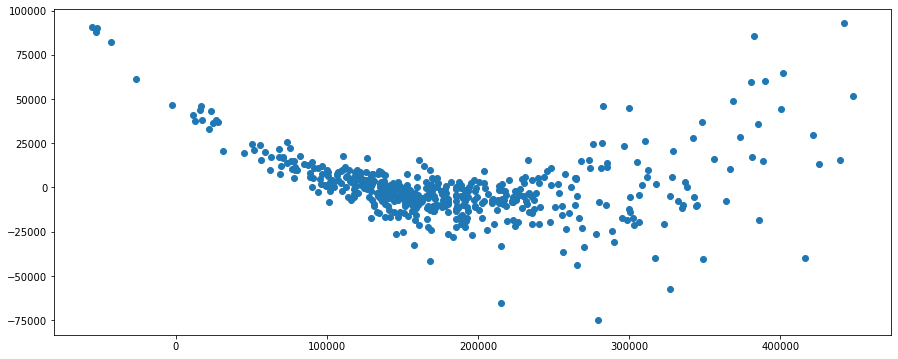

In [70]:
#Plot of the Errors
residuals = y_test - pred

plt.figure(figsize=(15,6))
plt.scatter(pred, residuals);

**2. Ridge and Lasso Comparison**

In [71]:
ridge.fit(X_train_ss, y_train)
ridge.score(X_train_ss, y_train)

0.973404960135063

In [72]:
ridge.score(X_test_ss, y_test)

0.9207287228690891

In [73]:
pred_r = ridge.predict(X_test_ss)
r2_score(y_test, pred_r)

0.9207287228690891

**MSE and RMSE**

In [86]:
mse = sklearn.metrics.mean_squared_error(y_test, pred_r)
mse

526216971.84853715

In [83]:
import math 

In [87]:
rmse = math.sqrt(mse)
rmse

22939.41960574716

**3.Import data(test) from EDA_test**

In [ ]:
df_test = pd.read_csv("./datasets/test_final.csv")
df_test.shape

In [ ]:
# #compare against train df
df_train.shape

Further exploration is required. Feature number dont tally 

**4. Missing columns**

In [ ]:
# As only certain columns are used to run the models, 
# we will be looking at the features instead
features = [col for col in df_train._get_numeric_data().columns if col != 'saleprice']

missing_features = [col for col in features if ~np.isin(col,df_test.columns)]
missing_features

In [ ]:
df_test = pd.concat([df_test, pd.DataFrame(columns = missing_features)]).fillna(0)
df_test[features].shape

In [ ]:
#Check for null values
(df_test.isnull().sum())[df_test.isnull().sum() > 0].sort_values(ascending=False)

In [ ]:
# Check for any duplicates
df_test.duplicated().sum()

In [ ]:
#features = [col for col in df_test._get_numeric_data().columns if col != 'saleprice']
prediction = df_test[features]
X_testdf_ss = ss.transform(df_test[features])
df_test['saleprice'] = lasso.predict(X_testdf_ss)
df_test['id'] = df_test['id'].astype(int)
kaggle_submission = df_test[['id','saleprice']].set_index('id')

In [ ]:
kaggle_submission.to_csv('./datasets/kaggle_submission.csv')